In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import h5py
from scipy.io import loadmat, savemat
from sklearn.model_selection import ShuffleSplit
from sklearn import svm
import torch
import torch.nn as nn
import torchvision.models as models
%matplotlib inline

/home/joeldapello/anaconda3/envs/torch/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def getWholeImages(impath):
    imgs = loadmat(impath)['img_mat'][0]
    prepped_imgs = []
    for i in range(imgs.shape[0]):
        img = Image.fromarray(imgs[i]).resize([227,227])
        rgb_img = Image.new("RGB", img.size)
        rgb_img.paste(img)
        prepped_imgs.append(np.array(rgb_img))
                                              
    prepped_imgs = np.array(prepped_imgs)
    prepped_imgs = np.transpose(prepped_imgs,(0,3,1,2))
    prepped_imgs = prepped_imgs/255 # normalize between 0-1
    return prepped_imgs

def getClasses(classPath):
    classes = loadmat(classPath)
    classes = np.squeeze(classes['data']['truth'][0,0])
    return classes

def getOccludedImgsByIdx(file, idx):
    dataset = file['dataset']
    imstack_ref = dataset[0,idx]
    imstack = np.transpose(file[imstack_ref],(3,0,1,2))/255
    return imstack

def polarize(tensor):
    new_tensor = tensor.copy()
    new_tensor[tensor>0]=1
    new_tensor[tensor==0]=-1
    new_tensor[tensor<0]=-1
    return new_tensor

In [3]:
vgg16 = models.vgg16(pretrained=True)
sel = [0,1,3,4]
vgg16.classifier = nn.Sequential(*[list(vgg16.classifier.children())[i] for i in sel])
vgg16.children

<bound method Module.children of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [4]:
## run whole images through, extracting fc7 represenations
impath = '../imageData/fullImages_325.mat'
X = getWholeImages(impath)
X = torch.tensor(X).float()
X = X.reshape(-1,13,*X.shape[1:]) # stack of 25 13 image sets

fc7_full = []
for x in X:
    out = vgg16.forward(x).detach().numpy()
    fc7_full.append(out)
    
fc7_full = np.array(fc7_full).reshape(325,4096)
X = X.reshape(325,*X.shape[2:])

In [28]:
fc7_full.shape

(325, 4096)

In [6]:
occludedImgFile = h5py.File('../imageData/occludedImgs_13000.mat', 'r')

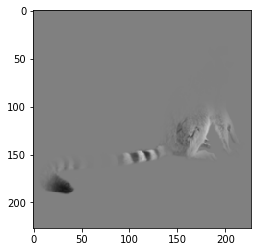

In [8]:
i = 40
plt.imshow(np.transpose(getOccludedImgsByIdx(occludedImgFile,i)[10],(1,2,0)))
# plt.imshow(np.transpose(X[i],(1,2,0)))
imstack_i = getOccludedImgsByIdx(occludedImgFile,i)
imstack_i = torch.tensor(imstack_i[::2]).float()

In [9]:
occludedImgFile = h5py.File('../imageData/occludedImgs_13000.mat', 'r')
num_objs = occludedImgFile['dataset'].shape[1]

fc7_occ = []

for i in range(num_objs):
    imstack_i = getOccludedImgsByIdx(occludedImgFile,i)
    imstack_i = torch.tensor(imstack_i[::2]).float()
    out = vgg16.forward(imstack_i).detach().numpy()
    fc7_occ.append(out)
    
fc7_occ = np.array(fc7_occ)
fc7_occ.shape

(325,)

In [11]:
# convert feature values to 1,-1
fc7_full_polarized = polarize(fc7_full)
fc7_occ_polarized = np.array([polarize(i) for i in fc7_occ])
fc7_full_polarized.shape,fc7_occ_polarized.shape

((325, 4096), (325,))

In [12]:
classPath = '../imageData/fullImages_325_labels.mat'
classes = getClasses(classPath)

In [14]:
savemat('../featureData/vgg15FullAndOccPol_325.mat', {
    'fc7_full':fc7_full,
    'fc7_occ':fc7_occ,
    'fc7_full_polarized':fc7_full_polarized,
    'fc7_occ_polarized':fc7_occ_polarized,
    'classes':classes
})

ugh, now run 'featureAttractors.m', which will generate the hopfield network and run fc7_test and tc7_test_occ for 256 timesteps, saving the results to 'fc7_hop_trajs.mat'